In [1]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(DBI, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source("src/database/startup.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/database/query/pairing.R")
source("src/database/query/analysis.R")
source("src/pairing/displaying.R")
source("src/pairing/combining.R")
source("src/database/plot.R")
source("notebooks/integrazioni_nazionali/SCIA/procedures/taggers.R")
dataset <- "SCIA"
conns <- load_dbs()


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [2]:
query <- glue::glue_sql(
    "
        WITH state_station AS (
            SELECT DISTINCT on (s.id)
                s.dataset,
                s.id,
                s.geom,
                s.geog
            FROM station_geo s
            WHERE s.dataset = {dataset}
        )
        SELECT
            sx.dataset AS dataset_x,
            sx.id AS id_x,
            sy.dataset AS dataset_y,
            sy.id AS id_y,
            ST_Distance(sx.geog, sy.geog) AS distance
        FROM state_station sx
        JOIN state_station sy
        ON ST_DWithin(sx.geog, sy.geog, 8000)
        WHERE sx.id != sy.id
    ",
    .con = conns$stations
)
close_stations <- dbGetQuery(conns$stations, query)
dbWriteTable(
    conns$data,
    "close_stations_tmp",
    close_stations,
    overwrite = TRUE
)


In [3]:
sf::st_read(conns$station, query = "SELECT * FROM station_geo LIMIT 10")


Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



id,previous_id,dataset,name,network,lon,lat,elevation,state,first_registration,last_registration,valid_days,original_id,original_dataset,passed_qc1,geog,glo30m_elevation,glo30asec_elevation,geom
<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<date>,<int>,<chr>,<chr>,<lgl>,<pq_ggrph>,<dbl>,<dbl>,<POINT [arc_degree]>
1,1,ARPAFVG,Barcis,ARPAFVG,12.57103,46.19320,468,Friuli-Venezia Giulia,2009-01-01,2022-12-31,5102,103400,ARPAFVG,NA,0101000020E6100000000000C05D242940000000E0BA184740,466.41455,568.17437744,POINT (12.57103 46.1932)
2,2,ARPAFVG,Grado Meteo,ARPAFVG,13.37329,45.68035,0,Friuli-Venezia Giulia,2009-01-01,2022-12-31,5099,178200,ARPAFVG,NA,0101000020E6100000000000C01FBF2A40000000C015D74640,0.00000,0.02744355,POINT (13.37329 45.68035)
3,4,ARPAFVG,Musi 2,ARPAFVG,13.27258,46.30727,600,Friuli-Venezia Giulia,2009-01-01,2022-12-31,5050,231600,ARPAFVG,NA,0101000020E6100000000000808F8B2A400000008054274740,529.99908,624.90771484,POINT (13.27258 46.30727)
4,5,ARPAFVG,Ariis,ARPAFVG,13.09000,45.87830,13,Friuli-Venezia Giulia,2014-01-16,2022-12-31,3256,ARI,ARPAFVG,NA,0101000020E610000000000080142E2A40000000206CF04640,12.60670,12.88204575,POINT (13.09 45.8783)
5,6,ARPAFVG,Barcis (fino al 18/02/2021),ARPAFVG,12.57103,46.19320,468,Friuli-Venezia Giulia,2004-12-03,2021-02-17,5895,BAR,ARPAFVG,NA,0101000020E6100000000000C05D242940000000E0BA184740,466.41455,568.17437744,POINT (12.57103 46.1932)
6,7,ARPAFVG,Borgo Grotta Gigante,ARPAFVG,13.76468,45.70938,275,Friuli-Venezia Giulia,2022-01-01,2022-12-31,364,BGG,ARPAFVG,NA,0101000020E61000000000004084872B4000000020CDDA4640,274.94293,272.64279175,POINT (13.76468 45.70938)
7,8,ARPAFVG,Bicinicco,ARPAFVG,13.24014,45.92881,33,Friuli-Venezia Giulia,2008-05-06,2022-12-31,5334,BIC,ARPAFVG,NA,0101000020E6100000000000A0F37A2A4000000020E3F64640,34.36507,33.85427094,POINT (13.24014 45.92881)
8,9,ARPAFVG,Boa Paloma (fino al 06/02/2018),ARPAFVG,13.56502,45.61829,5,Friuli-Venezia Giulia,2002-10-03,2022-12-31,5157,BOA,ARPAFVG,NA,0101000020E6100000000000A04A212B400000002024CF4640,0.00000,0.00000000,POINT (13.56502 45.61829)
9,10,ARPAFVG,Bordano (fino al 21/04/2021),ARPAFVG,13.08120,46.33276,230,Friuli-Venezia Giulia,2004-08-24,2021-04-20,6019,BOR,ARPAFVG,NA,0101000020E61000000000008092292A4000000000982A4740,221.90843,215.57212830,POINT (13.0812 46.33276)


In [4]:
dbExecute(conns$data, "SET memory_limit = '12.5GB'")


[1] 0

In [1]:
metadata <- tbl(conns$data, "stations_tmp") |> filter(dataset == "SCIA")
dbExecute(conns$data, "DROP TABLE IF EXISTS data_tmp")
data <- valid_data(conns$data) |>
    semi_join(metadata, join_by(station_id == id)) |>
    compute(temporary = FALSE, name = "data_tmp")
matches <- data |>
    valid_series() |>
    collect() |>
    series_matches(tbl(conns$data, "close_stations_tmp") |> collect(), asymmetric = TRUE, cmp = \(x, y) x > y) |>
    select(id_x, id_y, variable, distance)


ERROR: Error in tbl(conns$data, "stations_tmp"): non trovo la funzione "tbl"


In [6]:
analysis <- series_matches_analysis(matches, data, metadata)


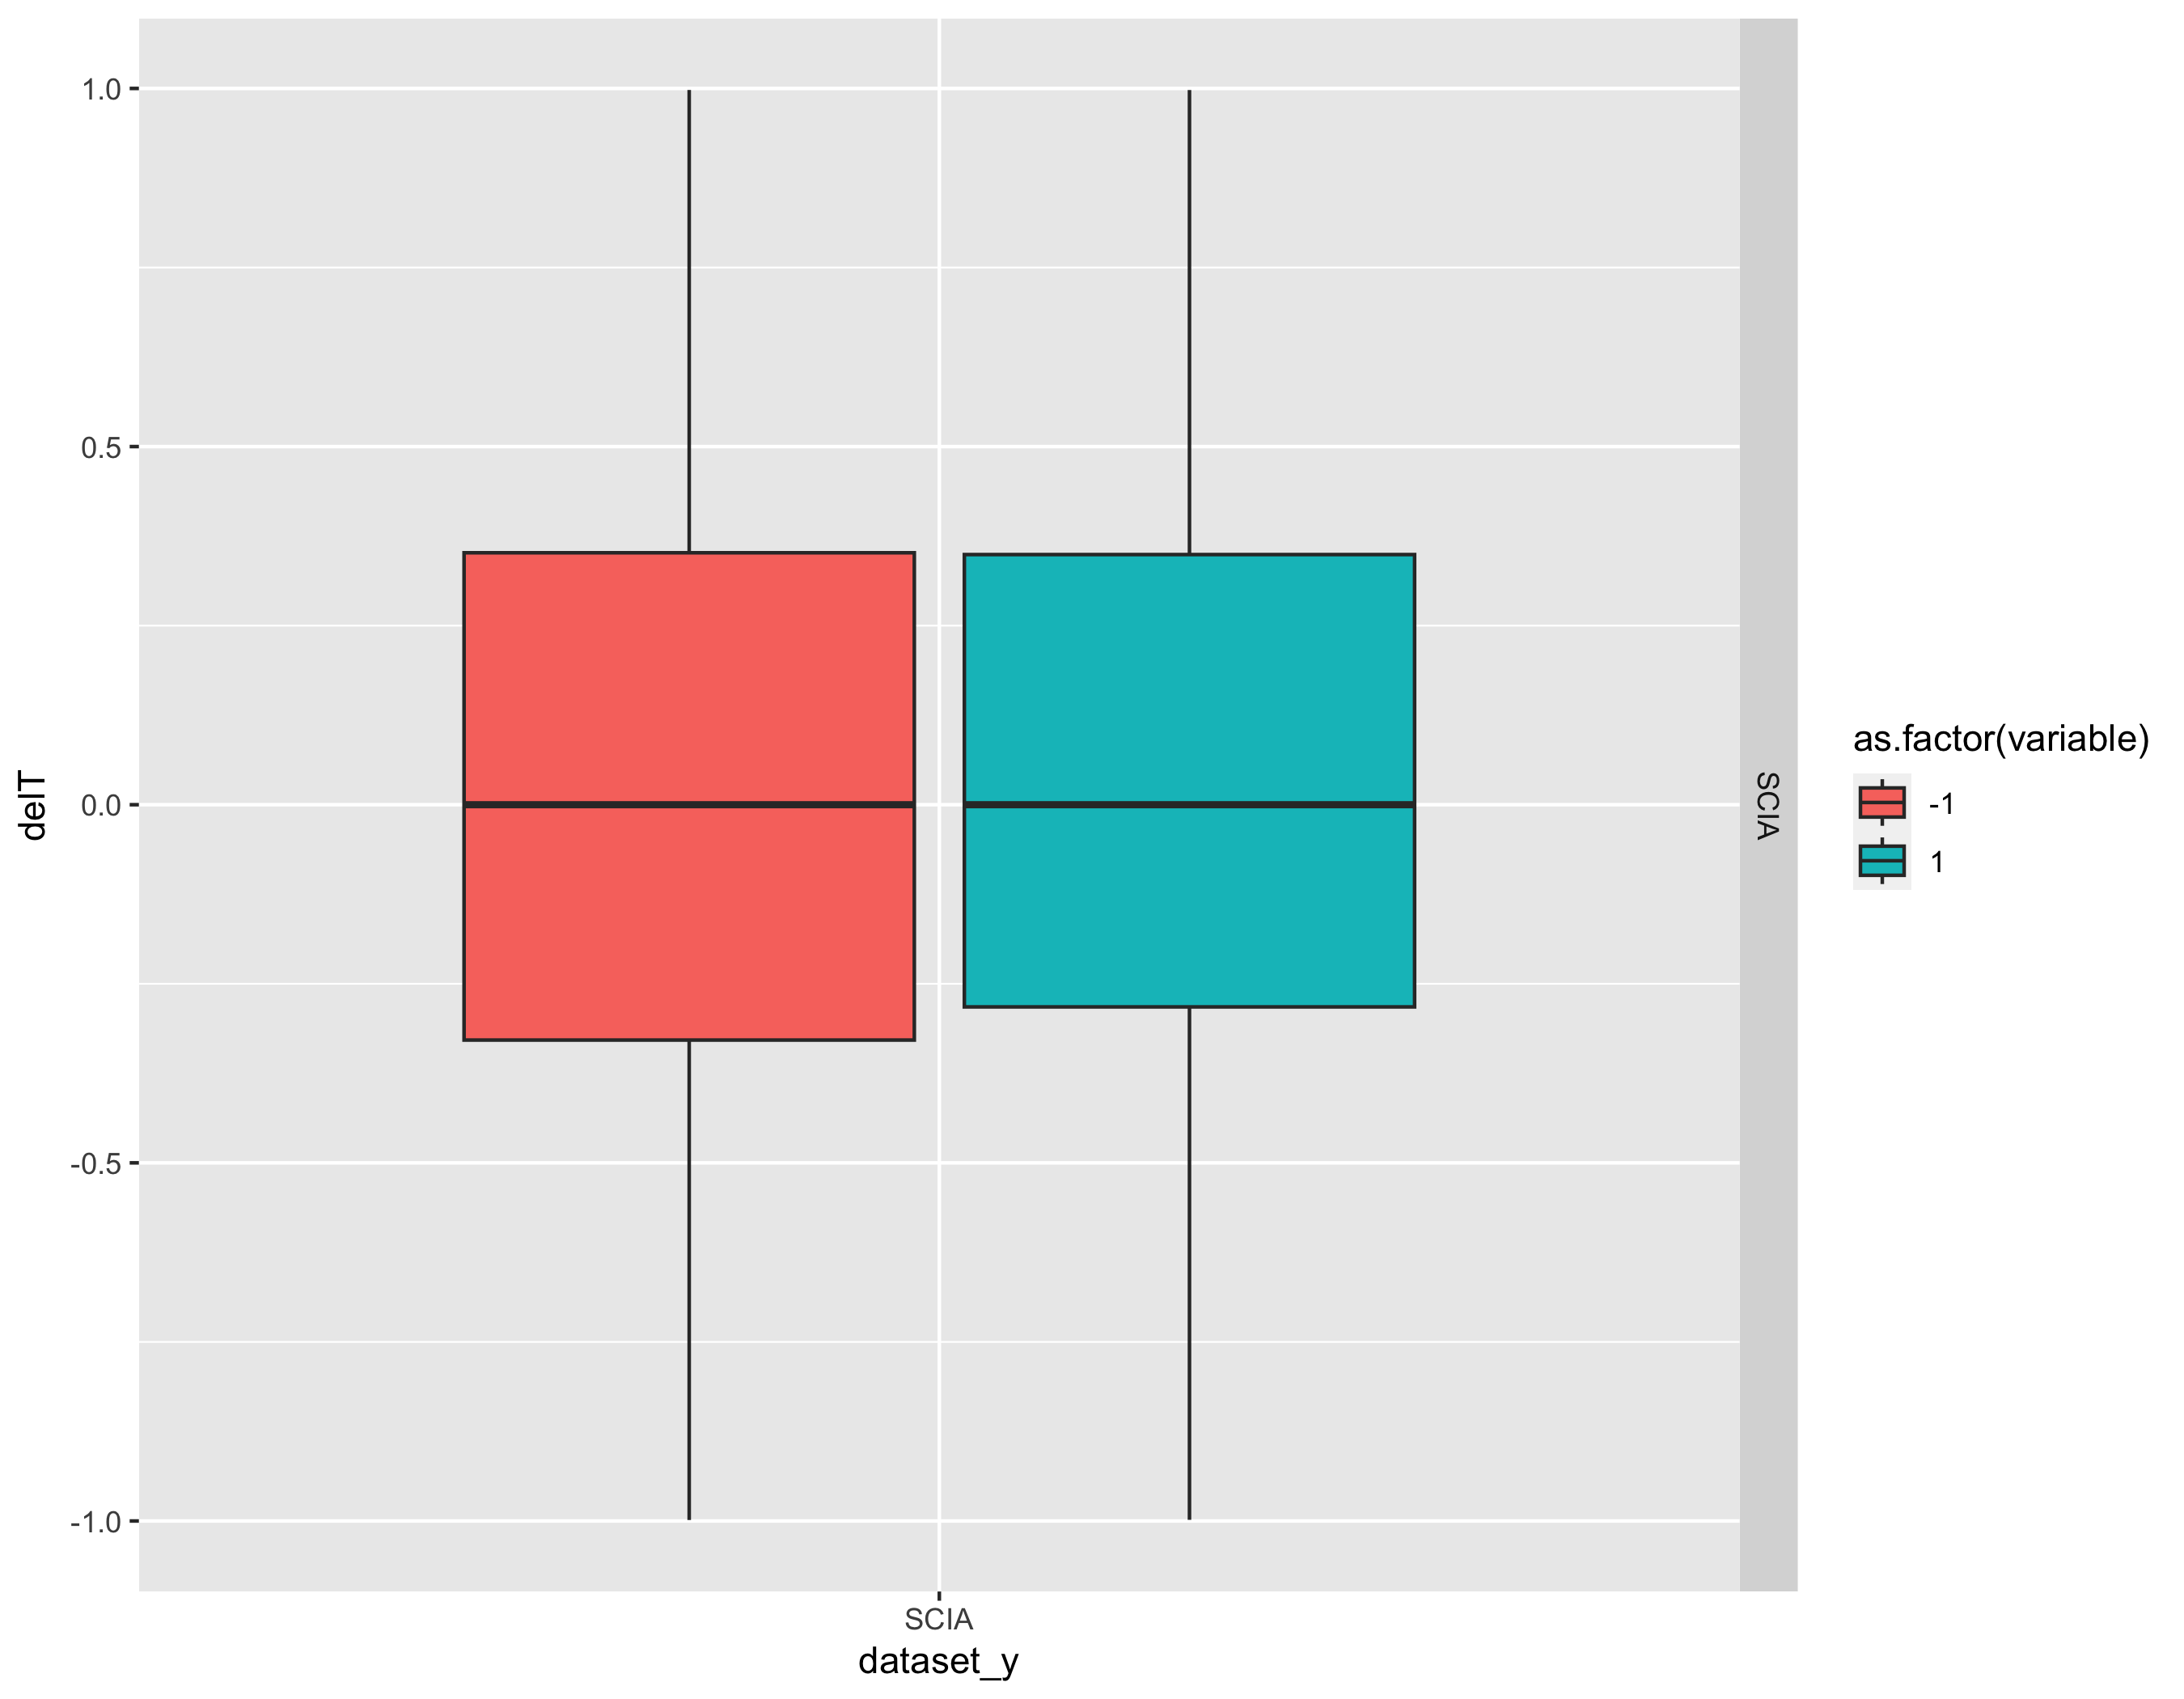

In [7]:
library(ggplot2)
ggplot(data = analysis |> filter(abs(delT) < 1)) +
    geom_boxplot(aes(x = dataset_y, y = delT, fill = as.factor(variable))) +
    facet_grid(dataset_x ~ .)


In [8]:
write_xslx_analysis(analysis, file.path("notebooks", "integrazioni_nazionali", "SCIA", "internal_analysis.xlsx"))


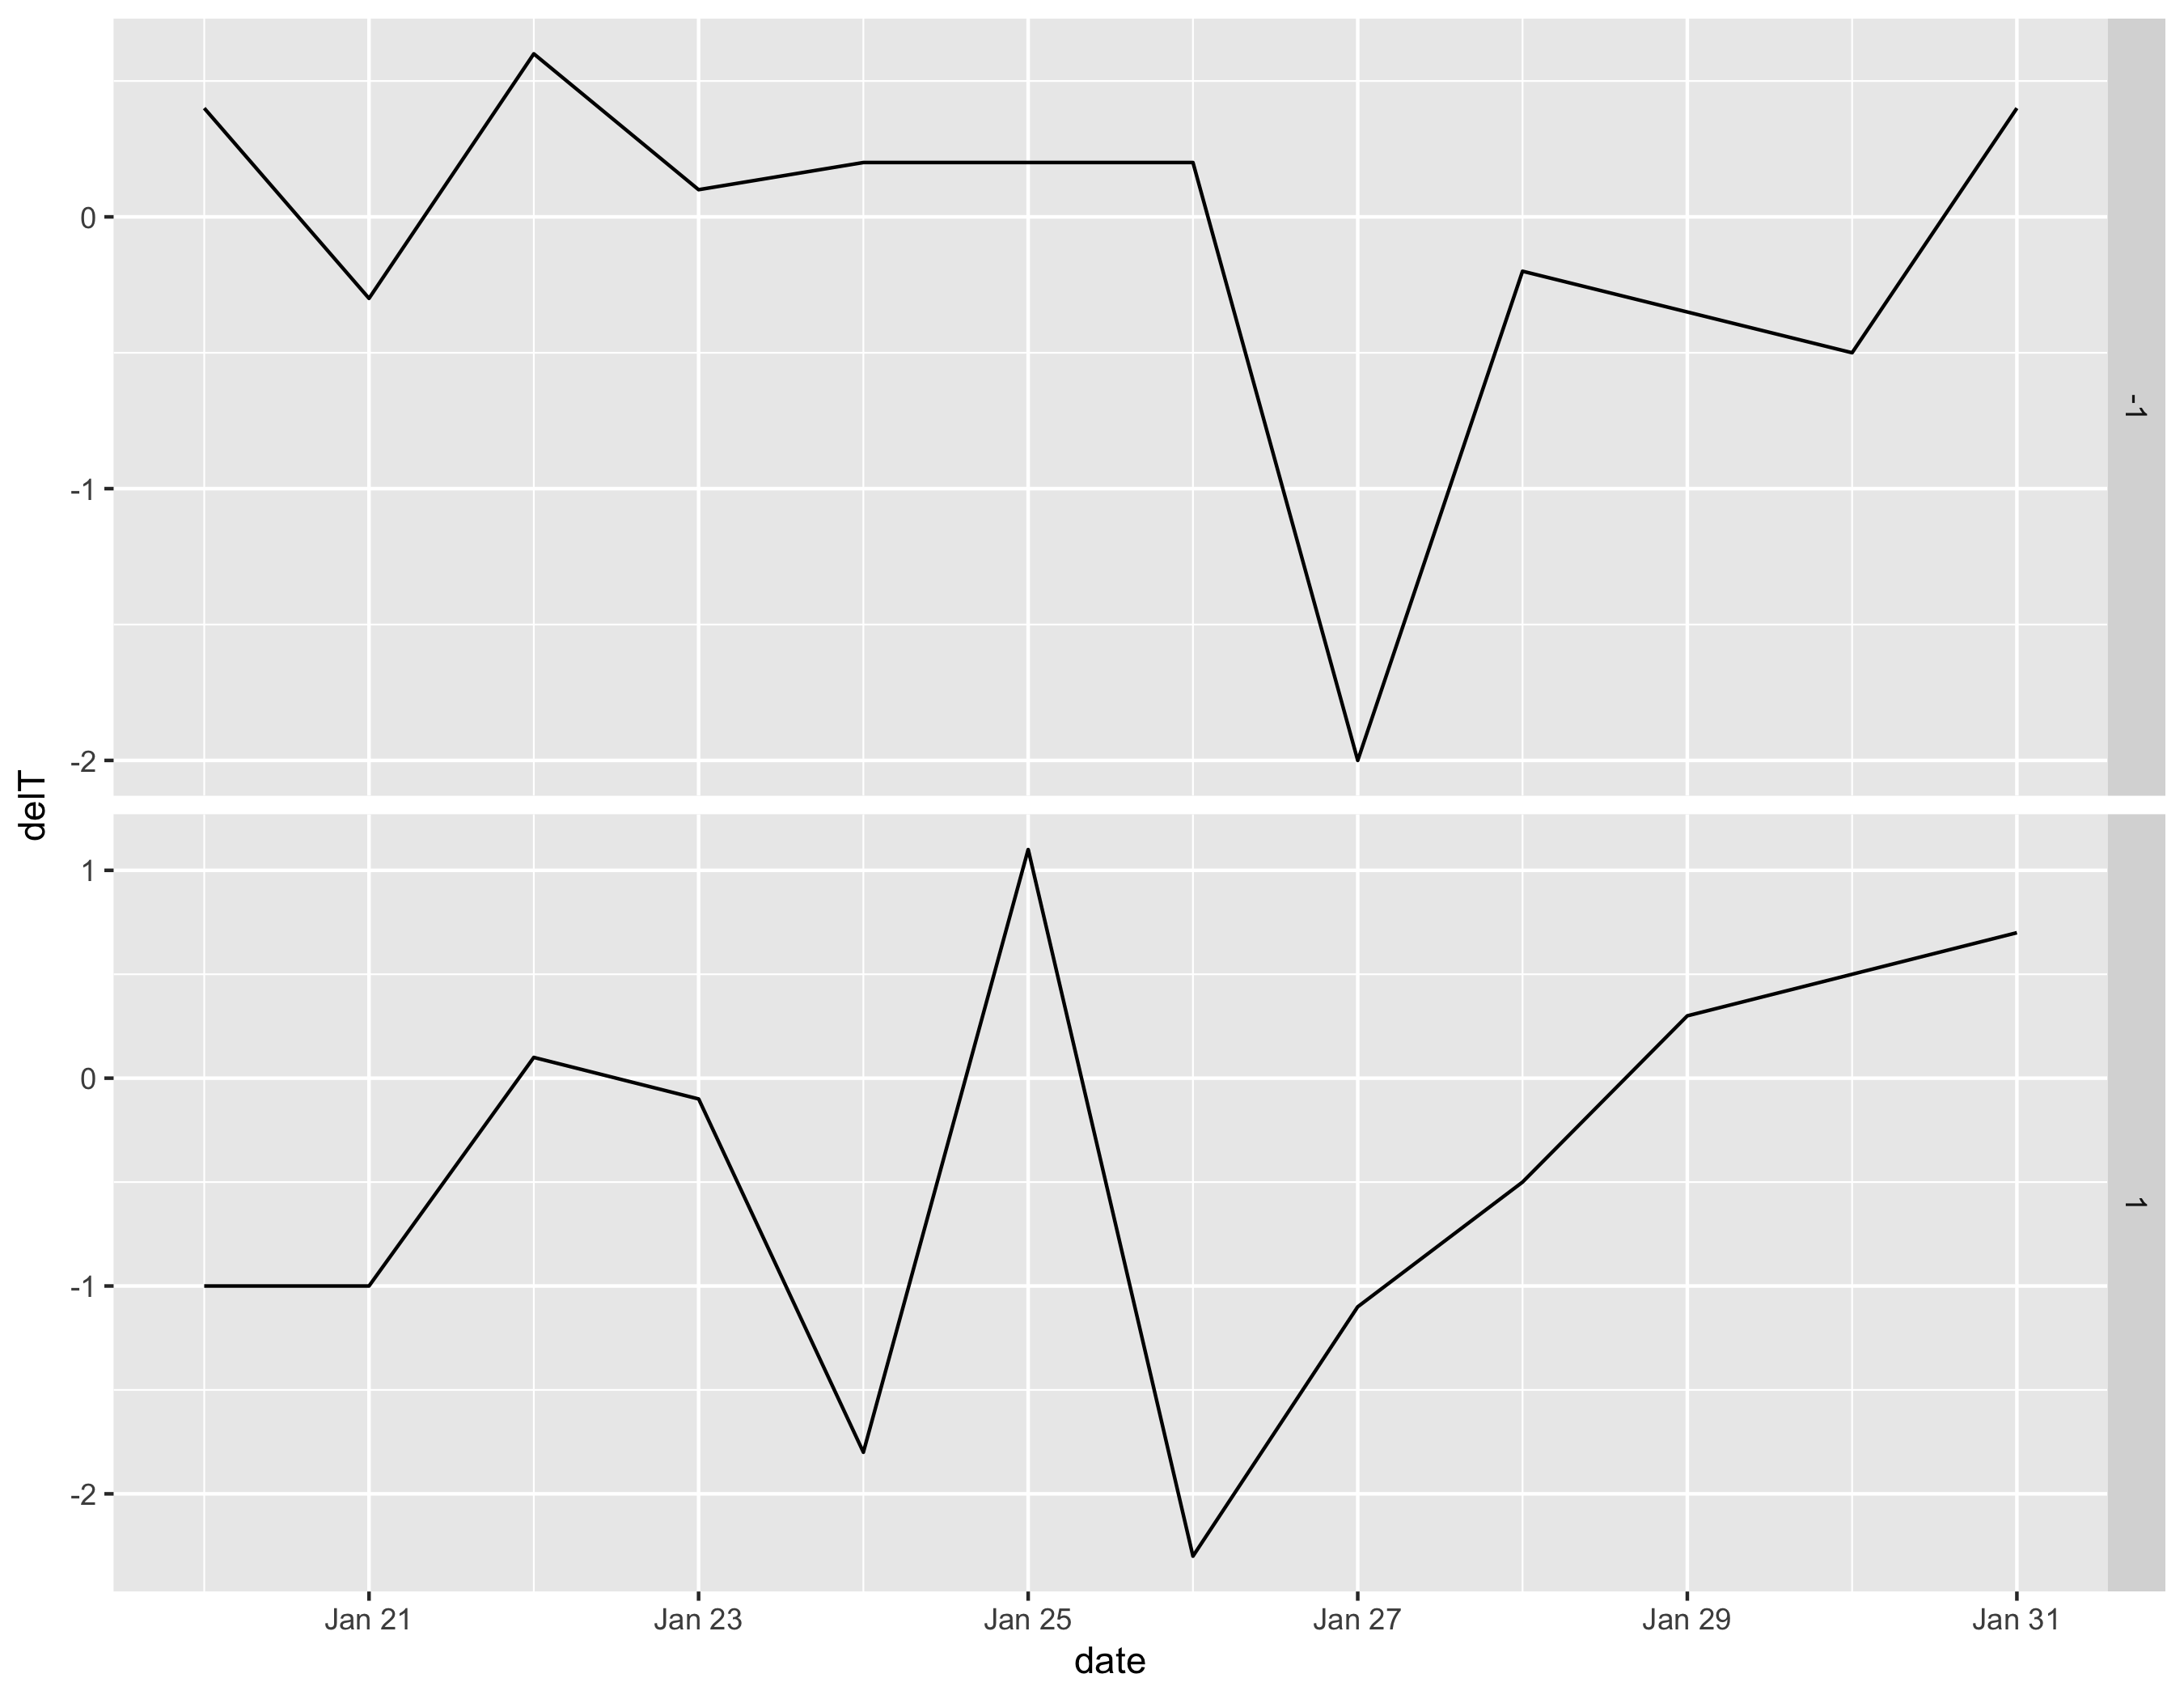

In [9]:
analysis |>
    filter(id_x == 4979L, id_y == 4978L) |>
    plot_diffs(conns$data)


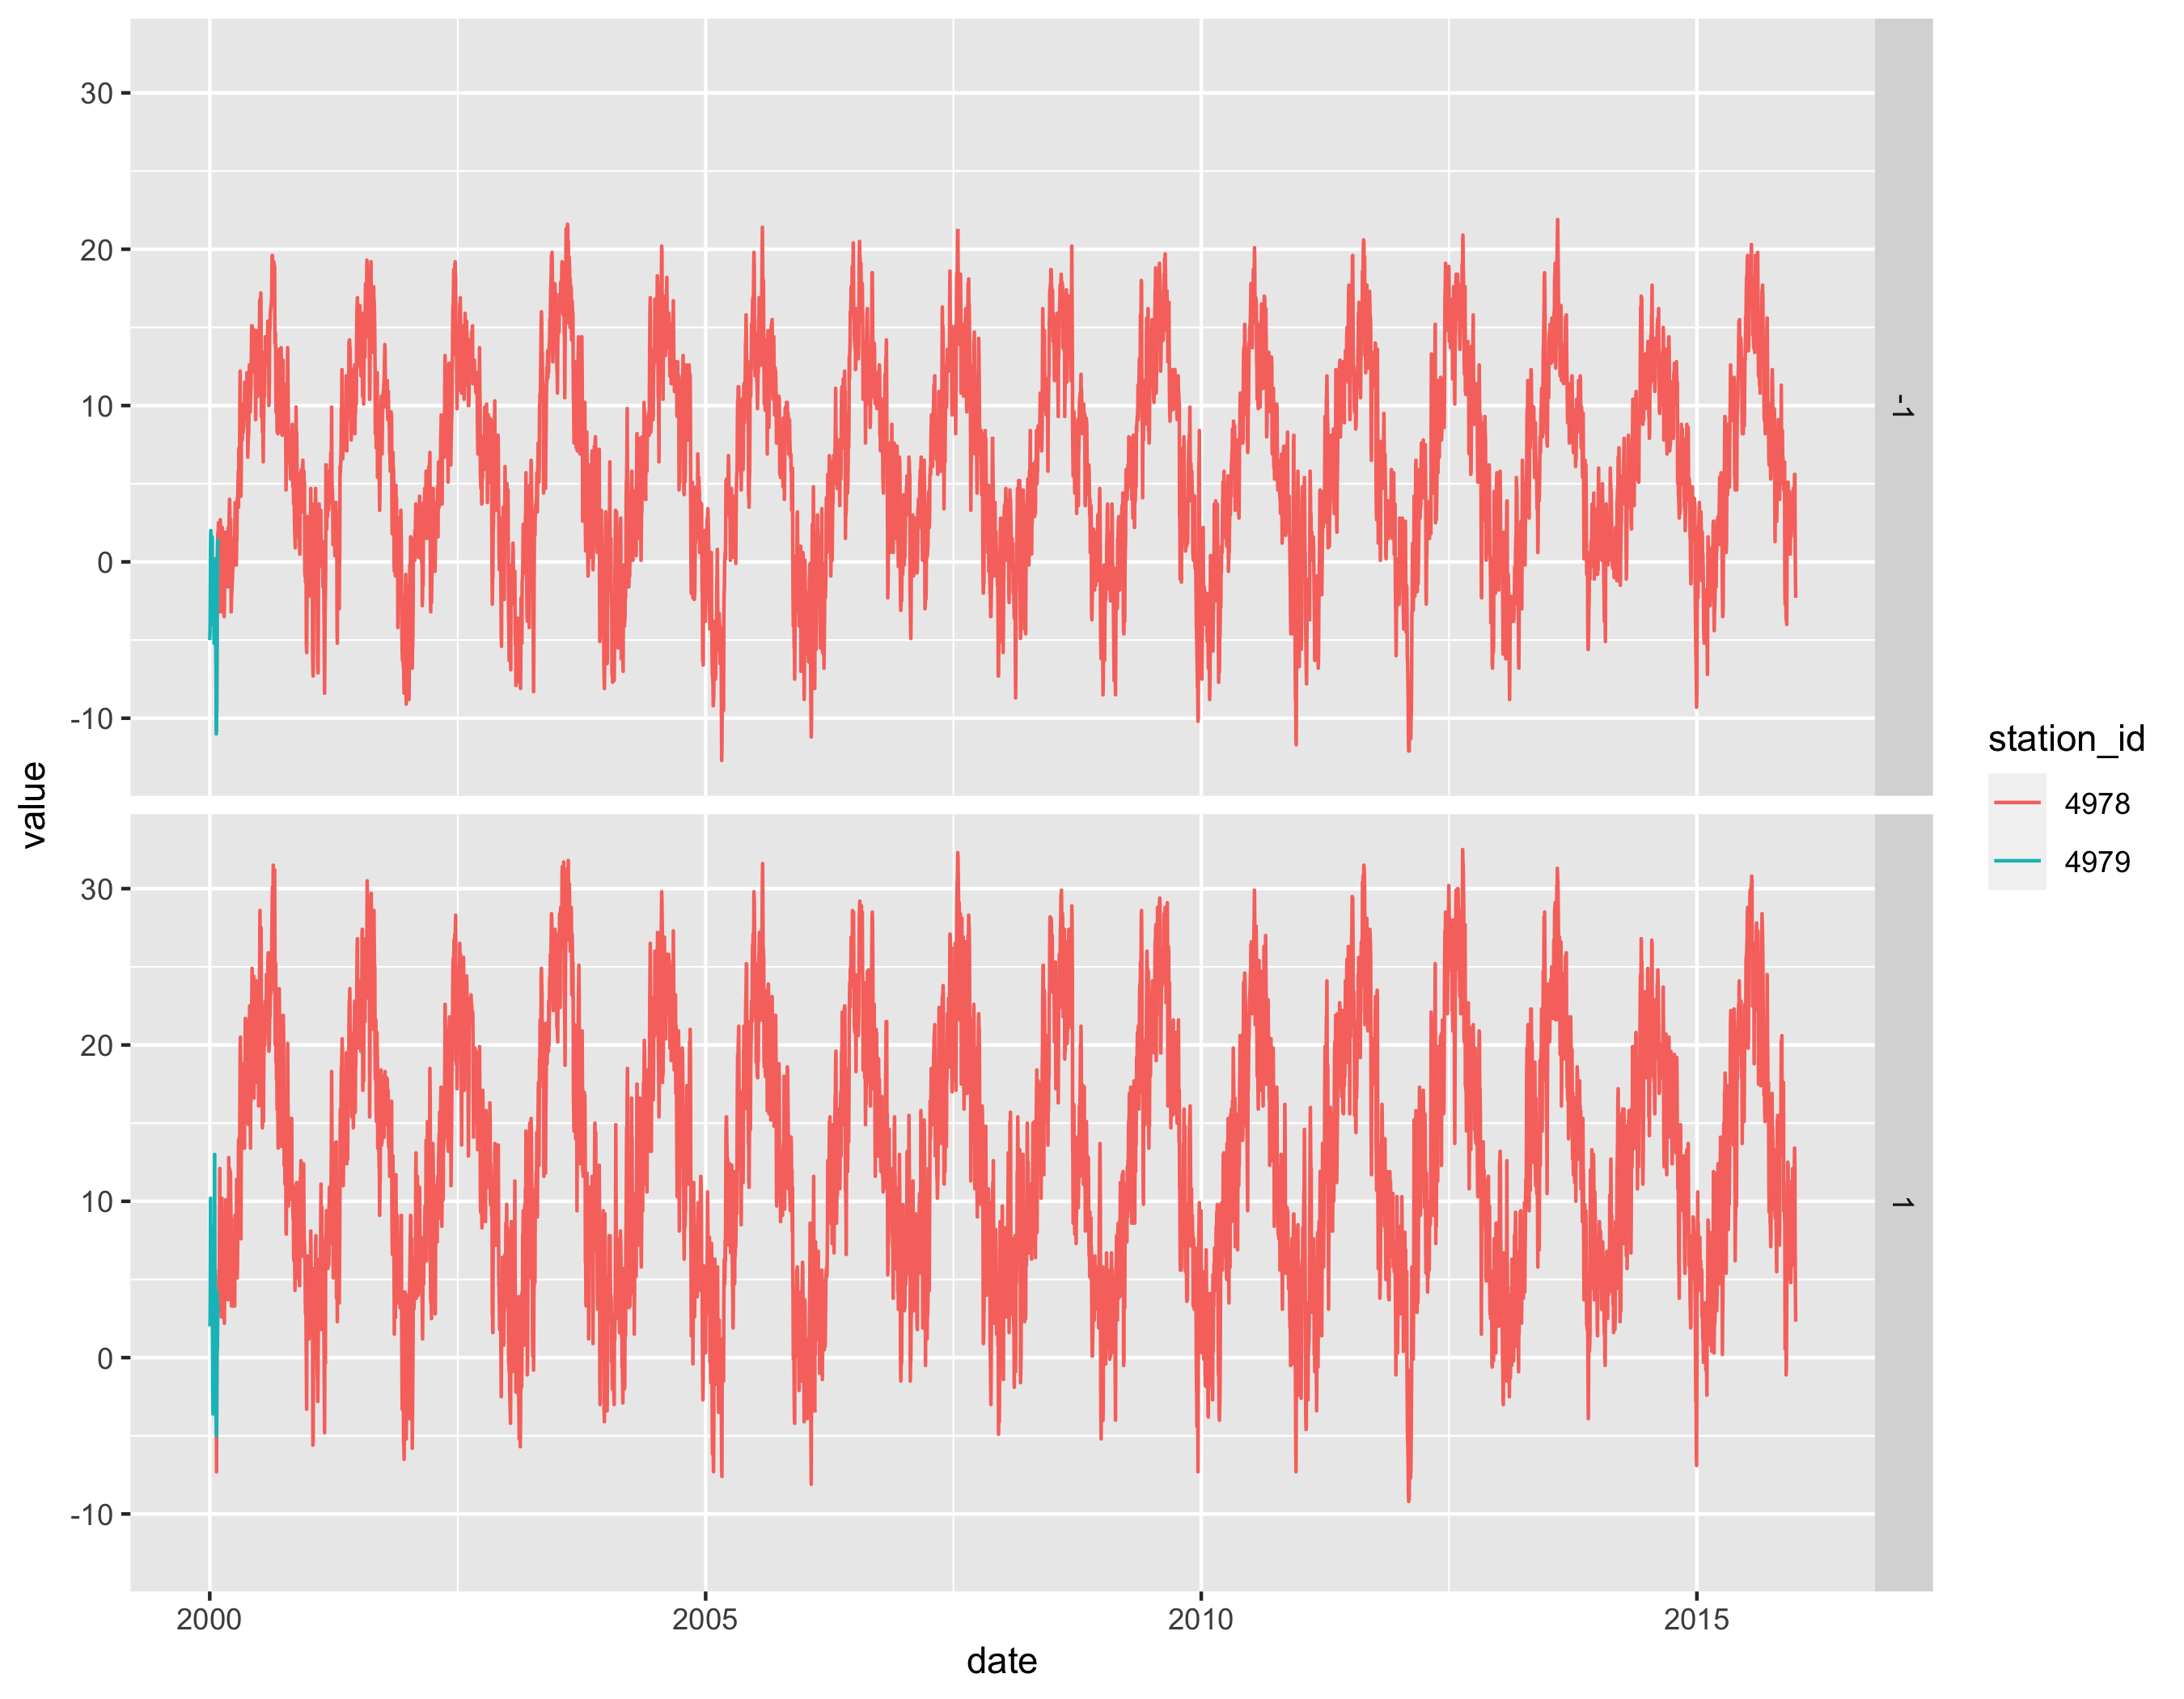

In [10]:
plot_stations(tibble(station_id = c(4979L, 4978L)), conns$data, same_period = FALSE)


In [11]:
tagged_analysis <- analysis |>
    tag_analysis()


In [34]:
edges <- tagged_analysis |>
    filter(variable == -1L) |>
    select(id_x, id_y, tag_to_merge)

# same_station_graph <- graph_using_edge(edges, edge_same_station)
merge_graph <- graph_from_isedge(edges, tag_to_merge) |> add_nonmatching(collect(metadata))


In [51]:
station_groups <- vertices_groups(merge_graph)


In [46]:
source("src/pairing/displaying.R")
map <- leaflet_groups(station_groups |> mutate(id = as.integer(id), gid = as.integer(gid)), conns$station, gid)


In [33]:
render_map(map)



Listening on http://127.0.0.1:6034



In [83]:
source("src/pairing/combining.R")
res <- merge_series_group(station_groups |> mutate(variable = -1L), metadata, data, c("SCIA"), dataset, valid_days)


In [85]:
merged <- res |> collect()


Warning message:
"ORDER BY is ignored in subqueries without LIMIT
i Do you need to move arrange() later in the pipeline or use window_order() instead?"


In [137]:
lagged_series_matches <- analysis |>
    select(offset_days, variable, id_x, id_y)
lagged_series_matches <- copy_to(data$src$con, lagged_series_matches, temporary = TRUE, overwrite = TRUE, name = "lagged_series_matches_tmp")

In [138]:
source("src/pairing/combining.R")
compute_corrections(lagged_series_matches, data)

variable,id_x,id_y,k0,k1,k2,k3
<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
-1,4454,4453,2.43244092,-0.042391178,0.395395049,0.026889738
-1,4459,4458,-0.07257998,0.052740276,-0.005319281,0.001543712
-1,4461,4460,-0.27979551,0.098324382,-0.001702809,0.082487619
-1,4464,4463,-0.05560883,0.017101322,-0.006023818,-0.002918218
-1,4471,4470,-0.05509145,-0.009694651,-0.015480925,-0.014317236
-1,4476,4475,-0.34999317,0.272231349,-0.069460875,0.027135909
-1,4478,4477,-0.36632231,0.153308426,-0.017677792,0.028439254
-1,4489,4488,-0.14293067,0.078737775,-0.012334511,0.009410398
-1,4498,4483,1.97497062,-0.664663357,0.159648678,-0.635570469


In [136]:
analysis |> filter(id_x == 6879L, valid_days_inters > 30 & valid_days_inters < 120) |> select(variable, id_x, id_y, f0, ends_with("T"))

variable,id_x,id_y,f0,maeT,delT,sdT,fsameint,monthlydelT,monthlymaeT,monthlysdT,climaticdelT,climaticmaeT,climaticsdT
<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1,6879,6144,0.01041667,2.765625,0.8302083,3.291076,0.13541667,1.978532,1.997273,1.480197,1.739563,1.882414,1.644668
1,6879,6144,0.00000000,6.828866,6.8288660,3.544596,0.04123711,7.615845,7.615845,2.609003,6.621706,6.621706,1.571633
